# **Chicago Crime Analysis**

**Author:** Meg Hutch

**Date:** June 7, 2020

**Data source:** Data was accessed from [data.cityofchicago](https://data.cityofchicago.org/Public-Safety/Crimes-2001-to-present/ijzp-q8t2). 

As described on their website:
> "This dataset reflects reported incidents of crime (with the exception of murders where data exists for each victim) that occurred in the City of Chicago from 2001 to present, minus the most recent seven days. Data is extracted from the Chicago Police Department's CLEAR (Citizen Law Enforcement Analysis and Reporting) system."

In this analysis several machine and deep learning methods are implemented to examine the utility of these advanced analytic methods in predicting crime in the city of Chicago. We also include exploratory sub-analyses of crimes reported during the historical civil unrests in late May 2020. 

In [1]:
import pandas as pd
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.colors
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import confusion_matrix, classification_report, roc_curve, roc_auc_score, accuracy_score, auc, precision_recall_fscore_support, f1_score, log_loss
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import KFold, GridSearchCV
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.feature_selection import SelectFromModel 
from sklearn.model_selection import StratifiedShuffleSplit

In [3]:
crime_df = pd.read_csv(r'C:\\Users\\User\\Box Sync/Projects/Chicago_Crimes/Crimes_-_2001_to_present.csv')
crime_areas = pd.read_csv(r'C:\\Users\\User\\Box Sync/Projects/Chicago_Crimes/CommAreas.csv'

C:\Users\User\Anaconda3\lib\site-packages\IPython\core\interactiveshell.py:3063: DtypeWarning: Columns (21) have mixed types.Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


# **Methods**

## **Data Pre-Processing**

1. Remove white space from column names
2. Concatenate Primary_Type and Description
3. Convert Year and Community_Area to type 'object'
4. Remove Primary_Type categories that occured < 1000 times
5. Remove missing values

In [4]:
# Step 1
crime_df.columns = crime_df.columns.str.replace(' ', '_')

# Step 2
crime_df["Primary_Type_Description"] = crime_df["Primary_Type"] + " " +  crime_df["Description"]

# Step 3
crime_df['Year'] = crime_df['Year'].astype(object)
crime_df['Community_Area'] = crime_df['Community_Area'].astype(object)

# Step 4
crime_df['freq'] = crime_df.groupby('Primary_Type')['Primary_Type'].transform('count')
crime_df = crime_df[crime_df.groupby('Primary_Type').freq.transform(len) > 1000]

# Step 5
crime_df = crime_df.dropna()

## **Model Preparation**

From exporing the data, many columns appear to be colinear to one another, and thus, to include all of these variables would be adding to much data into an already large dataset. For example, IURC (Illinois Unifrom Crime Reporting code) is said to be "Directly linked to the Primary Type and Description". Simiarly, FBI Code is a variable that describes the type of crime. Because our aim is to predict Primary_Type, we thus remove any variables that may leak information about our primary outcome. **Step 1**, shows the data we decided to keep in our preliminary models.

1. Select columns of interest - we keep **Primary_Type**, **Location_Description**, **Year**, and **Community_Area**. 

After selecting our columns of interest, we further divide our dataset into inputs (crime_x) and our output variable (crime_y).

2. Create x and y dataframes

**Steps 3 and 4** we process the x and y dataframes appropriately. All inputs in crime_x are one-hot encoded, while crime_y categorical values are coded as a number instead

3. One-hot encode categorical inputs in crime_x
4. Recode crime_y to convert categorical labels to numeric 

Lastly, we shuffle and then split our x and y datasets into training and test sets, using a 75/25% split respectively, where our primary outcome variable is stratified to ensure that each Primary_Type crime of our output is proportionally represented in each dataset.

In [ ]:
# Step 1
crime_model = crime_df[['Primary_Type', 'Location_Description', 'Year', 'Community_Area']]

# Step 2
crime_x = crime_model[['Location_Description', 'Year', 'Community_Area']]
crime_y = crime_model[['Primary_Type']]

# Step 3
crime_x = pd.get_dummies(crime_x)

# Step 4
crime_y.loc[:, 'Primary_Type'] = pd.factorize(crime_y['Primary_Type'])[0].reshape(-1,1)

# Step 5
sss = StratifiedShuffleSplit(n_splits=1, test_size=0.25, random_state=0)
sss.get_n_splits(crime_x, crime_y)

for train_index, test_index in sss.split(crime_x, crime_y):
    print("TRAIN:", train_index, "TEST:", test_index)
    X_train, X_test = crime_x[train_index], crime_x[test_index]
    y_train, y_test = crime_y[train_index], crime_y[test_index]

## **Functions for Models**

**Logistic Regression**

**View ROC Curve**

This function will print an ROC Curve.

In [ ]:
# View ROC Curve
def ez_roc(model, x, y, pos_label=1):
    """prints a basic Recievor Operator Curve (ROC). 

    Keyword arguments:
    model -- a 'fitted' sklearn model object 
    x -- predictor matrix (dtype='numpy array', required)
    y -- outcome vector (dtype='numpy array', required)
    pos_label --binary label considered positive in y  (dtype='int', default=1)
    """
    from sklearn.metrics import roc_curve, auc

    model_name=type(model).__name__ # defining model name as the __name__ characteristic held by sklearn models

    y_proba = model.predict_proba(x)[:,1]
        
    fpr, tpr, thresholds = roc_curve(y, y_proba, pos_label=pos_label)
    roc_auc = auc(fpr, tpr)
    
    plt.title('ROC curve')
    ax1= plt.plot(fpr, tpr, 'b', label = '%s AUC = %0.3f' % (model_name, roc_auc), linewidth=2)
    plt.legend(loc = 'lower right')
    plt.plot([0, 1], [0, 1],'r--')
    plt.xlim([0, 1])
    plt.ylim([0, 1])
    plt.ylabel('True Positive Rate')
    plt.xlabel('False Positive Rate')
    return()

**Evaluate Model**

This model includes parameters for cross-fold validation and will return a plot of the area under the curve for each test. Additionally, as we are working with a multi-classification problem, we evaluate our logistic regression models with one-vs-one classification.

In [ ]:
def evaluate_model(model, x, y, cv = True):
    """prints common binary classification evaluation metrics and an ROC curve. 

    Keyword arguments:
    model -- a 'fitted' sklearn model object 
    x -- predictor matrix (dtype='numpy array', required)
    y -- outcome vector (dtype='numpy array', required)
    cv -- if True, prints  score from 5-fold crossvalidation (dtype='boolean', default='True')
    """
    import sklearn.metrics
    from sklearn.metrics import log_loss, average_precision_score, precision_recall_curve
    from sklearn.model_selection import cross_val_score
    from sklearn.model_selection import StratifiedKFold

    if cv==True:
        cv_results= cross_val_score(model, x, y, scoring='roc_auc_ovo_weighted', cv=StratifiedKFold(5))
        print("across 5 fold cv on trainingset, the model had \n", 
             "mean auroc: {:0.3f}".format(np.mean(cv_results)), "\n",
             "std auroc: {:0.3f}".format(np.std(cv_results))
             )

        base_cv_score=np.mean(cross_val_score(model, x, y, scoring='roc_auc_ovo_weighted', cv=StratifiedKFold(5)))

    print("###metrics on provided dataset:###")
    
    ##basic model performance
    y_hat = model.predict(x) # predicted classes using default 0.5 threshold
    y_proba = model.predict_proba(x)[:,] #predicted probabilities
    auc=roc_auc_score(y, y_proba, multi_class = 'ovr', average = 'weighted')
    #loss= log_loss(y, y_hat)

    print ('the AUC is: {:0.3f}'.format(auc))
    print("classification report:\n ", classification_report(y, y_hat, digits=3))

    ez_roc(model, x, y, pos_label=1) #plotting roc curve
    plt.show()

# **Results**

## **Descriptives**

**Top 10 Crimes**

The top 10 crimes included Theft, Battery, Criminal Damage, Narcotics, Assault, Other Offense, Motor Vehicle Theft, Deceptive Practice and Robbery.  

In [ ]:
crime_df10 = crime_df.Primary_Type.value_counts()
crime_df10 = crime_df10.head(10)

crime_df10 = pd.DataFrame(crime_df10)

plt1 = crime_df10.plot(kind="bar", color = "tomato")
plt1.tick_params(axis="x", labelsize = 10, labelrotation = 90)
plt1.set_title("Top 10 Crimes")

In [ ]:
crime_df.Description.value_counts()
crime_df.Primary_Type.value_counts() # much more descrition types

In [ ]:
crime_desc10 = crime_df.Description.value_counts()
crime_desc10 = crime_desc10.head(10)

crime_desc10 = pd.DataFrame(crime_desc10)

plt1 = crime_desc10.plot(kind="bar", color = "tomato")
plt1.tick_params(axis="x", labelsize = 10, labelrotation = 90)
plt1.set_title("Top 10 Crime Descriptions (Overall)")

**Top 10 Crimes and Descriptions**

In [ ]:
crime_df10 = crime_df.Primary_Type_Description.value_counts()
crime_df10 = crime_df10.head(10)

crime_df10 = pd.DataFrame(crime_df10)

plt1 = crime_df10.plot(kind="bar", color = "tomato")
plt1.tick_params(axis="x", labelsize = 10, labelrotation = 85)
plt1.set_title("Top 10 Primary Crimes & Descriptions")

**Top 10 Crime Locations**

In [ ]:
crime_df10 = crime_df.Location_Description.value_counts()
crime_df10 = crime_df10.head(10)

crime_df10 = pd.DataFrame(crime_df10)

plt1 = crime_df10.plot(kind="bar", color = "tomato")
plt1.tick_params(axis="x", labelsize = 10, labelrotation = 90)
plt1.set_title("Top 10 Locations")

**Top 10 Districts**

**Where do these map to?**

In [ ]:
crime_df10 = crime_df.District.value_counts()
crime_df10 = crime_df10.head(10)

crime_df10 = pd.DataFrame(crime_df10)

plt1 = crime_df10.plot(kind="bar", color = "tomato")
plt1.tick_params(axis="x", labelsize = 10, labelrotation = 90)
plt1.set_title("Top 10 Districts")

**Top 10 Communities**

In [ ]:
crime_df10 = crime_df.Community_Area.value_counts()
crime_df10 = crime_df10.head(10)

crime_df10 = pd.DataFrame(crime_df10)

plt1 = crime_df10.plot(kind="bar", color = "tomato")
plt1.tick_params(axis="x", labelsize = 10, labelrotation = 90)
plt1.set_title("Top 10 Communities")

# **Machine Learning Methods to Predict Crimes**

# **Analyses & Results**

## **Logistic Regression**

In [31]:
x = X_train[0:200000]
y = y_train[0:200000]

In [32]:
y = y.reshape(-1)
y.shape

(200000,)

###metrics on provided dataset:###


C:\Users\User\Anaconda3\lib\site-packages\ipykernel_launcher.py:30: RuntimeWarning: divide by zero encountered in true_divide
C:\Users\User\Anaconda3\lib\site-packages\ipykernel_launcher.py:30: RuntimeWarning: invalid value encountered in true_divide


the AUC is: 0.753
the Accuracy is: nan


C:\Users\User\Anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


classification report:
                precision    recall  f1-score   support

           0      0.487     0.174     0.256      8242
           1      0.000     0.000     0.000       788
           2      0.433     0.199     0.272     11216
           3      0.367     0.657     0.471     42457
           4      0.333     0.001     0.001      1411
           5      0.205     0.054     0.085     22751
           6      0.239     0.070     0.108     12424
           7      0.000     0.000     0.000       793
           8      0.000     0.000     0.000        28
           9      0.133     0.001     0.002     12499
          10      0.334     0.535     0.411     20295
          11      0.302     0.552     0.391     36693
          12      0.228     0.117     0.155      9116
          13      0.298     0.010     0.020      7565
          14      0.387     0.097     0.155      5730
          15      0.000     0.000     0.000      2304
          16      0.214     0.023     0.041       399
  

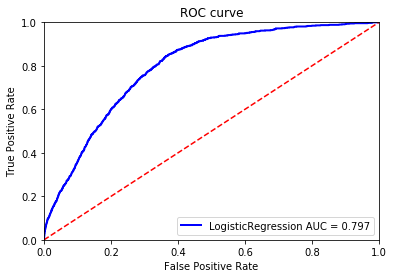

In [36]:
lr= LogisticRegression(penalty='l2', solver='newton-cg', random_state = 12345)
#fit model
lr.fit(x, y)
#evaluate model (on training data)
evaluate_model(lr, x, y, cv = False)

In [ ]:
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split



# Random Forest

# Deep Learning

# K-Nearest-Neighbors

In [ ]:
neigh = NearestNeighbors(n_neighbors=2)
neigh.fit(X)
NearestNeighbors(n_neighbors=2)

## is there a way to validate these...check past homework assignment perhaps?

In [ ]:
-KNN

-Logisitc Regression

-Random Forest

-PyTorch Neural Network

-Crime location map

-sub analysis since civil unrest

In [ ]:
#crime_areas = crime_areas[['AREA_NUMBE','COMMUNITY']]
#crime_areas = crime_areas.dropna()
#crime_areas.columns =['Community_Area', 'Community_Name']

In [ ]:
# remove '-' from the logintitude/latitude community_area entries
#crime_areas = crime_areas[~crime_areas.Community_Area.str.contains("-")]

# transition the column to type 'float'
#crime_df['Community_Area'] = crime_df['Community_Area'].astype(float)
#crime_areas['Community_Area'] = crime_areas['Community_Area'].astype(float)

# merge the seperate dataframes 
#crime_df = pd.merge(crime_df, crime_areas, on='Community_Area')
#crime_df.head(20)

In [ ]:
#unique, counts = np.unique(crime_df.Primary_Type, return_counts=True)
#print(unique)
#print(counts)